In [1]:
import torch
from torchvision.datasets import MNIST
from torch.utils.data import random_split, DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

import pickle
import base64
import sys

import hashlib
import json
from time import time
from time import sleep
import requests

%matplotlib inline
plt.rcParams['figure.figsize'] = [5, 5]

In [2]:
train_dataset = MNIST('/kaggle/working', train=True, download=True, transform=transforms.ToTensor())
test_dataset = MNIST('/kaggle/working', train=False, download=True, transform=transforms.ToTensor())

train_dataset, dev_dataset = random_split(train_dataset, [int(len(train_dataset) * 0.83), int(len(train_dataset) * 0.17)])

100%|██████████| 9912422/9912422 [04:33<00:00, 36260.69it/s]


Extracting /kaggle/working/MNIST/raw/train-images-idx3-ubyte.gz to /kaggle/working/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 1432117.91it/s]

Extracting /kaggle/working/MNIST/raw/train-labels-idx1-ubyte.gz to /kaggle/working/MNIST/raw




100%|██████████| 1648877/1648877 [00:48<00:00, 34141.19it/s]


Extracting /kaggle/working/MNIST/raw/t10k-images-idx3-ubyte.gz to /kaggle/working/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 14121963.50it/s]


Extracting /kaggle/working/MNIST/raw/t10k-labels-idx1-ubyte.gz to /kaggle/working/MNIST/raw



In [3]:
# MAKE SURE SAME FOR BOTH SERVER AND CLIENT CODE
total_train_size = len(train_dataset)
total_test_size = len(test_dataset)
total_dev_size = len(dev_dataset)

classes = 10
input_dim = 784

batch_size = 128
epochs_per_client = 3
learning_rate = 2e-2

In [4]:
# CONFIGURE BEFORE RUNNIG
# MAKE SURE SAME FOR BOTH SERVER AND ALL CLIENTS' CODE
num_clients = 2
rounds = 2

In [5]:
CHAIN_URL = 'https://2347b804-83c2-481a-9697-c5f6de62b5ab-00-2qo920vvfssrt.spock.replit.dev/chain'
MINE_URL = 'https://2347b804-83c2-481a-9697-c5f6de62b5ab-00-2qo920vvfssrt.spock.replit.dev/mine'
SEND_TRNS_URL = 'https://2347b804-83c2-481a-9697-c5f6de62b5ab-00-2qo920vvfssrt.spock.replit.dev/transactions/new'
GET_TRNS_URL = 'https://2347b804-83c2-481a-9697-c5f6de62b5ab-00-2qo920vvfssrt.spock.replit.dev/current'
PREV_BLK_URL = 'https://2347b804-83c2-481a-9697-c5f6de62b5ab-00-2qo920vvfssrt.spock.replit.dev/last'

In [6]:
total_train_size, total_dev_size, total_test_size

(49800, 10200, 10000)

In [7]:
def get_device():
    return torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader(DataLoader):
        def __init__(self, dl, device):
            self.dl = dl
            self.device = device

        def __iter__(self):
            for batch in self.dl:
                yield to_device(batch, self.device)

        def __len__(self):
            return len(self.dl)

device = get_device()

In [8]:
class FederatedNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(1, 20, 7)
        self.conv2 = torch.nn.Conv2d(20, 40, 7)
        self.maxpool = torch.nn.MaxPool2d(2, 2)
        self.flatten = torch.nn.Flatten()
        self.linear = torch.nn.Linear(2560, 10)
        self.non_linearity = torch.nn.functional.relu
        self.track_layers = {'conv1': self.conv1, 'conv2': self.conv2, 'linear': self.linear}

    def forward(self, x_batch):
        out = self.conv1(x_batch)
        out = self.non_linearity(out)
        out = self.conv2(out)
        out = self.non_linearity(out)
        out = self.maxpool(out)
        out = self.flatten(out)
        out = self.linear(out)
        return out

    def get_track_layers(self):
        return self.track_layers

    def apply_parameters(self, parameters_dict):
        with torch.no_grad():
            for layer_name in parameters_dict:
                self.track_layers[layer_name].weight.data *= 0
                self.track_layers[layer_name].bias.data *= 0
                self.track_layers[layer_name].weight.data += parameters_dict[layer_name]['weight']
                self.track_layers[layer_name].bias.data += parameters_dict[layer_name]['bias']

    def get_parameters(self):
        parameters_dict = dict()
        for layer_name in self.track_layers:
            parameters_dict[layer_name] = {
                'weight': self.track_layers[layer_name].weight.data,
                'bias': self.track_layers[layer_name].bias.data
            }
        return parameters_dict

    def batch_accuracy(self, outputs, labels):
        with torch.no_grad():
            _, predictions = torch.max(outputs, dim=1)
            return torch.tensor(torch.sum(predictions == labels).item() / len(predictions))

    def _process_batch(self, batch):
        images, labels = batch
        outputs = self(images)
        loss = torch.nn.functional.cross_entropy(outputs, labels)
        accuracy = self.batch_accuracy(outputs, labels)
        return (loss, accuracy)

    def fit(self, dataset, epochs, lr, batch_size=128, opt=torch.optim.SGD):
        dataloader = DeviceDataLoader(DataLoader(dataset, batch_size, shuffle=True), device)
        optimizer = opt(self.parameters(), lr)
        history = []
        for epoch in range(epochs):
            losses = []
            accs = []
            for batch in dataloader:
                loss, acc = self._process_batch(batch)
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
                loss.detach()
                losses.append(loss)
                accs.append(acc)
            avg_loss = torch.stack(losses).mean().item()
            avg_acc = torch.stack(accs).mean().item()
            history.append((avg_loss, avg_acc))
        return history

    def evaluate(self, dataset, batch_size=128):
        dataloader = DeviceDataLoader(DataLoader(dataset, batch_size), device)
        losses = []
        accs = []
        with torch.no_grad():
            for batch in dataloader:
                loss, acc = self._process_batch(batch)
                losses.append(loss)
                accs.append(acc)
        avg_loss = torch.stack(losses).mean().item()
        avg_acc = torch.stack(accs).mean().item()
        return (avg_loss, avg_acc)

In [9]:
class Client:
    def __init__(self, client_id, dataset):
        self.client_id = client_id
        self.dataset = dataset

    def get_dataset_size(self):
        return len(self.dataset)

    def get_client_id(self):
        return self.client_id

    def train(self, parameters_dict):
        net = to_device(FederatedNet(), device)
        net.apply_parameters(parameters_dict)
        train_history = net.fit(self.dataset, epochs_per_client, learning_rate, batch_size)
        print('{}: Loss = {}, Accuracy = {}'.format(self.client_id, round(train_history[-1][0], 4), round(train_history[-1][1], 4)))
        return net.get_parameters()

In [10]:
def compress_params(params):
  compressed = pickle.dumps(params)
  params_bytes = base64.b64encode(compressed)
  params_bystr = params_bytes.decode('ascii')
  return params_bystr

def decompress_params(params):
  decompressed = params.encode("ascii")
  decompressed = base64.b64decode(decompressed)
  decompressed = pickle.loads(decompressed)
  return decompressed

In [11]:
examples_per_client = total_train_size // num_clients
client_datasets = random_split(train_dataset, [min(i + examples_per_client,
           total_train_size) - i for i in range(0, total_train_size, examples_per_client)])
clients = [Client('client_' + str(i), client_datasets[i]) for i in range(num_clients)]

In [12]:
global_net = to_device(FederatedNet(), device)
history = []

In [13]:
# MAKE SURE THE API IS RUNNING AT THIS POINT
curr_parameters = global_net.get_parameters()
curr_parameters_compressed = compress_params(curr_parameters)

In [14]:
response = requests.get(CHAIN_URL)
print(response.json())

{'chain': [{'index': 1, 'previous_hash': 1, 'proof': 100, 'timestamp': 1714343360.121466, 'transactions': []}], 'length': 1}


In [15]:
# LAST CODE BEFORE LOOP
new_transaction = {
    'type': 'global',
    'trainer': 'GLOBAL',
    'gradient': curr_parameters_compressed
}

# Send the transaction to the server
response = requests.post(SEND_TRNS_URL, json=new_transaction)
print(response.json())
response = requests.get(MINE_URL)
print(response.json())

{'message': 'Transaction will be added to Block 2'}
{'index': 2, 'message': 'New Block Forged', 'previous_hash': 'a60c135642a92ba230ab2f2fb21af92c7602a993d6e6856adb9a5c872f65ba41', 'proof': 30390, 'transactions': [{'gradients': 'gASVfxIAAAAAAAB9lCiMBWNvbnYxlH2UKIwGd2VpZ2h0lIwMdG9yY2guX3V0aWxzlIwSX3JlYnVpbGRfdGVuc29yX3YylJOUKIwNdG9yY2guc3RvcmFnZZSMEF9sb2FkX2Zyb21fYnl0ZXOUk5RCTBAAAIACigps/JxG+SBqqFAZLoACTekDLoACfXEAKFgQAAAAcHJvdG9jb2xfdmVyc2lvbnEBTekDWA0AAABsaXR0bGVfZW5kaWFucQKIWAoAAAB0eXBlX3NpemVzcQN9cQQoWAUAAABzaG9ydHEFSwJYAwAAAGludHEGSwRYBAAAAGxvbmdxB0sEdXUugAIoWAcAAABzdG9yYWdlcQBjdG9yY2gKRmxvYXRTdG9yYWdlCnEBWA4AAAA5NjYzMDE5MTk5NTQ3MnECWAMAAABjcHVxA03UA050cQRRLoACXXEAWA4AAAA5NjYzMDE5MTk5NTQ3MnEBYS7UAwAAAAAAAOWt270TLo29zlEevdM9Bz5Olgm+AUj0vbxTWL3jcsG9sx6JvcxiEL43+wU8ZLYNvvTvBr7XcUy94V8rvWTXDr5wdKo916tQvVyRfD0Tmrm8zeEEPrV6qj0BZK46vtf7PUNkEb7uNd+8bvAAvWgb3z2AHok97uSuPQqYq73uG0E9KNnwvdcAMr2j7eq905BEPTfgUL3D/OE93IwvvaCfoj0MeLi9fqsOPsDQE70RmNo9HIV2vW7mrz38p369QGahPe5ZZrw1StQ9ChPJPVza1T0BgFQ

In [16]:
global_param_history = []

for i in range(rounds):
  response = requests.get(GET_TRNS_URL)

  while response.json()['current-transaction-length'] != num_clients:
    sleep(45)
    response = requests.get(GET_TRNS_URL)

  response = requests.get(MINE_URL)
  response = requests.get(PREV_BLK_URL)

  block_trns = response.json()['chain']['transactions']

  local_params = []
  for i in block_trns:
    if i['type'] == 'local':
      local_params.append({'trainer': i['trainer'], 'gradients': i['gradients'], 'data-size': i['data-size']})

  total_data_size = 0
  for i in local_params:
    total_data_size += i['data-size']

  new_parameters = dict([(layer_name, {'weight': 0, 'bias': 0}) for layer_name in curr_parameters]) # Fresh new params for every round

  for i in local_params:
    client_parameters = decompress_params(i['gradients'])
    fraction = i['data-size'] / total_data_size
    for layer_name in client_parameters:
      new_parameters[layer_name]['weight'] += fraction * client_parameters[layer_name]['weight']
      new_parameters[layer_name]['bias'] += fraction * client_parameters[layer_name]['bias']

  global_param_history.append(new_parameters)

  new_parameters_compressed = compress_params(new_parameters)

  new_transaction = {
    'type': 'global',
    'trainer': 'GLOBAL',
    'gradient': new_parameters_compressed
  }

  # Send the transaction to the server
  response = requests.post(SEND_TRNS_URL, json=new_transaction)
  print(response.json())
  response = requests.get(MINE_URL)

{'message': 'Transaction will be added to Block 4'}


In [19]:
response = requests.get(CHAIN_URL)
print(response.json())

{'chain': [{'index': 1, 'previous_hash': 1, 'proof': 100, 'timestamp': 1714343360.121466, 'transactions': []}, {'index': 2, 'previous_hash': 'a60c135642a92ba230ab2f2fb21af92c7602a993d6e6856adb9a5c872f65ba41', 'proof': 30390, 'timestamp': 1714343372.6386273, 'transactions': [{'gradients': 'gASVfxIAAAAAAAB9lCiMBWNvbnYxlH2UKIwGd2VpZ2h0lIwMdG9yY2guX3V0aWxzlIwSX3JlYnVpbGRfdGVuc29yX3YylJOUKIwNdG9yY2guc3RvcmFnZZSMEF9sb2FkX2Zyb21fYnl0ZXOUk5RCTBAAAIACigps/JxG+SBqqFAZLoACTekDLoACfXEAKFgQAAAAcHJvdG9jb2xfdmVyc2lvbnEBTekDWA0AAABsaXR0bGVfZW5kaWFucQKIWAoAAAB0eXBlX3NpemVzcQN9cQQoWAUAAABzaG9ydHEFSwJYAwAAAGludHEGSwRYBAAAAGxvbmdxB0sEdXUugAIoWAcAAABzdG9yYWdlcQBjdG9yY2gKRmxvYXRTdG9yYWdlCnEBWA4AAAA5NjYzMDE5MTk5NTQ3MnECWAMAAABjcHVxA03UA050cQRRLoACXXEAWA4AAAA5NjYzMDE5MTk5NTQ3MnEBYS7UAwAAAAAAAOWt270TLo29zlEevdM9Bz5Olgm+AUj0vbxTWL3jcsG9sx6JvcxiEL43+wU8ZLYNvvTvBr7XcUy94V8rvWTXDr5wdKo916tQvVyRfD0Tmrm8zeEEPrV6qj0BZK46vtf7PUNkEb7uNd+8bvAAvWgb3z2AHok97uSuPQqYq73uG0E9KNnwvdcAMr2j7eq905BEPTfgUL3D/OE93IwvvaCfoj0MeLi9fq

Global Model Evaluation

In [20]:
train_loss, train_acc = global_net.evaluate(train_dataset)
dev_loss, dev_acc = global_net.evaluate(dev_dataset)
print('After round {}, train_loss = {}, dev_loss = {}, dev_acc = {}\n'.format(0, round(train_loss, 4),
             round(dev_loss, 4), round(dev_acc, 4)))
history.append((train_loss, dev_loss))

After round 0, train_loss = 2.3067, dev_loss = 2.3067, dev_acc = 0.1044



In [21]:
for i in range(len(global_param_history)):
  global_net.apply_parameters(global_param_history[i])
  train_loss, train_acc = global_net.evaluate(train_dataset)
  dev_loss, dev_acc = global_net.evaluate(dev_dataset)
  print('After round {}, train_loss = {}, dev_loss = {}, dev_acc = {}\n'.format(i+1, round(train_loss, 4),
              round(dev_loss, 4), round(dev_acc, 4)))
  history.append((train_loss, dev_loss))

After round 1, train_loss = 0.1761, dev_loss = 0.1804, dev_acc = 0.9506

After round 2, train_loss = 1.3714, dev_loss = 1.3767, dev_acc = 0.9468



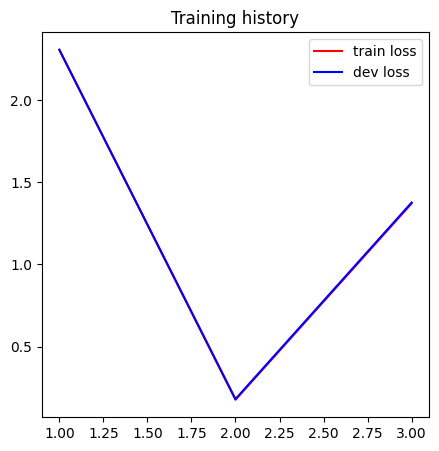

In [22]:
plt.plot([i + 1 for i in range(len(history))], [history[i][0] for i in range(len(history))], color='r', label='train loss')
plt.plot([i + 1 for i in range(len(history))], [history[i][1] for i in range(len(history))], color='b', label='dev loss')
plt.legend()
plt.title('Training history')
plt.show()